In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.4 MB/s eta 0:00:00


In [2]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from tabulate import tabulate

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Reducción de dimensiones
from sklearn.decomposition import PCA

# Regresión lineal
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import bartlett

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Pretty print
from pprint import pprint

#SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# split a univariate sequence into samples
def TrainingSet(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [4]:
#cargar datos desde drive acceso libre
FILEID = "143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Departamentos.zip && rm -rf /tmp/cookies.txt
!unzip Departamentos.zip
!dir

--2023-06-19 20:10:35--  https://docs.google.com/uc?export=download&confirm=t&id=143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM
Resolving docs.google.com (docs.google.com)... 172.217.203.138, 172.217.203.113, 172.217.203.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kp751lnlp32k27qp4cfch82tbqtm6gdi/1687205400000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=fa311b32-0f82-4311-a8f0-40d84e646022 [following]
--2023-06-19 20:10:35--  https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kp751lnlp32k27qp4cfch82tbqtm6gdi/1687205400000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=fa311b32-0f82-4311-a8f0-40d84e646022
Resolving doc-0o-6k-docs.googleusercontent.com (doc-0o-6k-docs.googleusercontent.com)... 74.125.196.1

In [5]:
ls # Se verifica los archivos existenes en directorio

 Colombia_Demanda_Horaria.xlsx   Departamentos.zip
 Colombia.xlsx                   sample_data/
 D_Departamental_Horaria.xlsx    Todos_Departamentos_Depurado.xlsx
'Demanda_Caribe Ajustado.xlsx'


In [6]:
df=pd.read_excel('/content/Colombia_Demanda_Horaria.xlsx')

In [7]:
df = df.drop('Date', axis=1)
# Se establese nuevamente en el indice temporal en la nueva variable 'a', y al DataFrame se incliye la informacion de frecuencia horaria 'H' de la base de datos
date_rng = pd.date_range(start='2000-01-01', end='2023-01-01', freq='H')
# Establece el índice del DataFrame a las fechas generadas
df.set_index(date_rng[0:-1], inplace=True)

In [8]:
df.info() # Se verifica informacion de la BD

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201624 entries, 2000-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Demand  201624 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


In [9]:
Ts1=df['2020-10-01':'2022-12-31'] # Un año
print('Tamaño Serie Horaria: ', len(Ts1))

Tamaño Serie Horaria:  19728


In [10]:
# data = data.asfreq('h') # Set frequency for h
# Se separa el train y test
train_df = Ts1[:15781]
test_df = Ts1[15781:]

In [11]:
b=auto_arima(train_df, seasonal=True, trace=True)# Se corre verificador automatico de parametros SARIMAX

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=31.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=446356.205, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=435700.934, Time=3.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=437453.744, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=446354.208, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=435159.317, Time=3.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=435140.232, Time=5.74 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=434638.839, Time=6.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=434483.547, Time=10.52 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=44.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=30.91 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=434481.547, Time=6.86 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=434636.837, Time=3.66 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=28.67 sec
 ARIMA(4,1,1)(0,0,0)[0]     

In [12]:
c=b.order
b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15781
Model:               SARIMAX(5, 1, 0)   Log Likelihood             -217234.773
Date:                Mon, 19 Jun 2023   AIC                         434481.547
Time:                        20:14:31   BIC                         434527.546
Sample:                    10-01-2020   HQIC                        434496.771
                         - 07-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8211      0.004    183.214      0.000       0.812       0.830
ar.L2         -0.2374      0.008    -31.116      0.000      -0.252      -0.222
ar.L3          0.1651      0.008     21.084      0.000       0.150       0.180
ar.L4         -0.0898      0.006    -14.166      0.000      -0.102      -0.077
ar.L5         -0.1001      0.007    -15.178      0.000      -0.113      -0.087
sigma2      5.113e+10   5.74e-14    8.9e+23      0.000    5.11e+10    5.11e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):            186635.98
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.83e+38. Standard errors may be unstable.
"""

In [13]:
mod = SARIMAX(train_df, order=c, seasonal_order=(1,0,0,24)) # Se crea modelo SARIMAX con resultado anteior Best model:  ARIMA(5,1,0)(1,0,0)[24]
res = mod.fit() # Se entrena Modelo

In [14]:
start =len(train_df)# len(train_df) # limintes para prediccion 15781
end = 19728-1 #len(train_df) + len(test_df) - 1 # limintes para prediccion
prediction = res.predict(start, end).rename('Prediction') # Se realiza prediccion

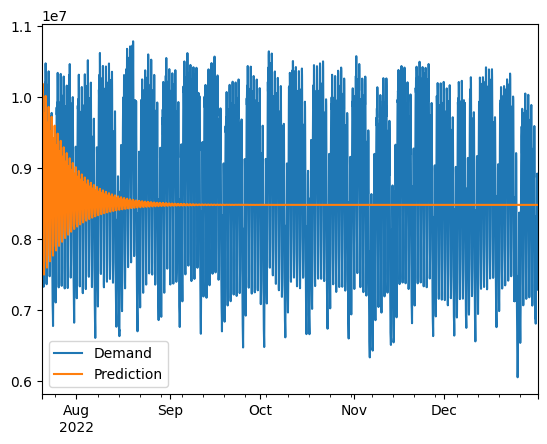

In [15]:
test_df.plot(legend=True) # Se dibuja Test
#train_df.plot(legend=True)
prediction.plot(legend=True) # Se dibuja prediccion
# plt.xlim(460560,460770)
plt.show()

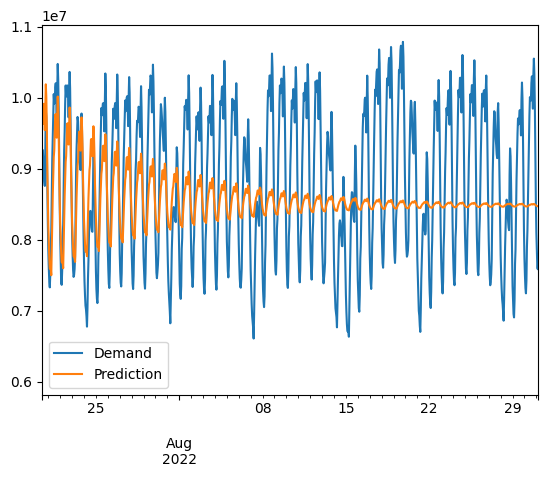

In [16]:
test_df.plot(legend=True) # Se dibuja Test
#train_df.plot(legend=True)
prediction.plot(legend=True) # Se dibuja prediccion
plt.xlim(460643,461643)
plt.show()

In [18]:
# Calculo de medias de rendimiendo
col_names, MSE, RMSE, MAE, R2, cnSMAPE, P_Value_Cor, P_Value_TT, P_Value_Var = ['Metrics', 'SARIMAX'], ["MSE"], ["RMSE"], ["MAE"], ["R2"],['cnSMAPE'], ['P_Value_Cor'],['P_Value_TT'],['P_Value_Var']
MSE.append(round(mean_squared_error(test_df, prediction, squared=False),5))
RMSE.append(mean_squared_error(test_df, prediction, squared=True))
MAE.append(round(mean_absolute_error(test_df, prediction),5))
R2.append(round(r2_score(test_df, prediction),5))
mape=mean_absolute_percentage_error(test_df, prediction)
smape = 2 * mape * 100 / (100 - mape)
cnSMAPE.append(round(1-(smape/2),5))
correlation, p_value = pearsonr(test_df.values.reshape(len(test_df)), prediction.values)
P_Value_Cor.append(p_value)
t_statistic, p_value = ttest_ind(test_df.values.reshape(len(test_df)), prediction.values)
P_Value_TT.append(p_value)
statistic, p_value = bartlett(test_df.values.reshape(len(test_df)), prediction.values)
P_Value_Var.append(p_value)

tablas = [MSE, RMSE, MAE, R2, cnSMAPE, P_Value_Cor, P_Value_TT, P_Value_Var ]

print(tabulate(tablas, headers=col_names, tablefmt="fancy_grid"))

╒═════════════╤══════════════════╕
│ Metrics     │          SARIMAX │
╞═════════════╪══════════════════╡
│ MSE         │      1.08545e+06 │
├─────────────┼──────────────────┤
│ RMSE        │      1.17821e+12 │
├─────────────┼──────────────────┤
│ MAE         │ 952129           │
├─────────────┼──────────────────┤
│ R2          │     -0.00334     │
├─────────────┼──────────────────┤
│ cnSMAPE     │      0.89129     │
├─────────────┼──────────────────┤
│ P_Value_Cor │      8.37631e-60 │
├─────────────┼──────────────────┤
│ P_Value_TT  │      7.9225e-51  │
├─────────────┼──────────────────┤
│ P_Value_Var │      0           │
╘═════════════╧══════════════════╛


In [19]:
start =len(train_df)# len(train_df) # limintes para prediccion 15781
end = len(train_df)+99 #len(train_df) + len(test_df) - 1 # limintes para prediccion
prediction = res.predict(start, end).rename('Prediction') # Se realiza prediccion

In [20]:
len(prediction)

100

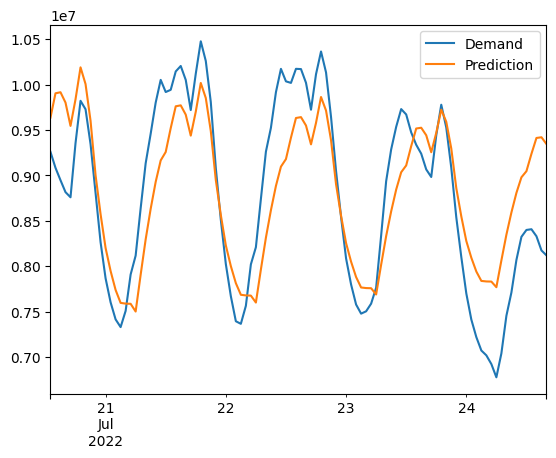

In [21]:
test_df[0:100].plot(legend=True) # Se dibuja Test
#train_df.plot(legend=True)
prediction.plot(legend=True) # Se dibuja prediccion
# plt.xlim(460560,460770)
plt.show()

In [22]:

col_names, MSE, RMSE, MAE, R2, cnSMAPE, P_Value_Cor, P_Value_TT, P_Value_Var = ['Metrics', 'SARIMAX'], ["MSE"], ["RMSE"], ["MAE"], ["R2"],['cnSMAPE'], ['P_Value_Cor'],['P_Value_TT'],['P_Value_Var']
MSE.append(round(mean_squared_error(test_df[0:100], prediction, squared=False),5))
RMSE.append(mean_squared_error(test_df[0:100], prediction, squared=True))
MAE.append(round(mean_absolute_error(test_df[0:100], prediction),5))
R2.append(round(r2_score(test_df[0:100], prediction),5))
mape=mean_absolute_percentage_error(test_df[0:100], prediction)
smape = 2 * mape * 100 / (100 - mape)
cnSMAPE.append(round(1-(smape/2),5))
correlation, p_value = pearsonr(test_df[0:100].values.reshape(len(test_df[0:100])), prediction.values)
P_Value_Cor.append(p_value)
t_statistic, p_value = ttest_ind(test_df[0:100].values.reshape(len(test_df[0:100])), prediction.values)
P_Value_TT.append(p_value)
statistic, p_value = bartlett(test_df[0:100].values.reshape(len(test_df[0:100])), prediction.values)
P_Value_Var.append(p_value)

tablas = [MSE, RMSE, MAE, R2, cnSMAPE, P_Value_Cor, P_Value_TT, P_Value_Var ]

print(tabulate(tablas, headers=col_names, tablefmt="fancy_grid"))

╒═════════════╤══════════════════╕
│ Metrics     │          SARIMAX │
╞═════════════╪══════════════════╡
│ MSE         │ 592360           │
├─────────────┼──────────────────┤
│ RMSE        │      3.5089e+11  │
├─────────────┼──────────────────┤
│ MAE         │ 510848           │
├─────────────┼──────────────────┤
│ R2          │      0.65973     │
├─────────────┼──────────────────┤
│ cnSMAPE     │      0.94085     │
├─────────────┼──────────────────┤
│ P_Value_Cor │      6.81935e-25 │
├─────────────┼──────────────────┤
│ P_Value_TT  │      0.828707    │
├─────────────┼──────────────────┤
│ P_Value_Var │      0.00740535  │
╘═════════════╧══════════════════╛
